# TensorFlow Content-based Filtering with Embedding (Paragraph2vec)


http://cs.stanford.edu/~quocle/paragraph_vector.pdf

http://research.google.com/pubs/pub44894.html

https://www.tensorflow.org/tutorials/word2vec

## Movielens Dataset

[Notebook](MovieLens Small Dataset.ipynb)

### TensorFlow Paragraph2vec

In [1]:
import csv

items = dict() # dict of id -> text (words)
ignored = list()

with open('movielens/ml-latest-small/plots.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_plot in reader:
        if movie_plot == 'N/A':
            ignored.append(movie_id)
            continue
        items[movie_id] = movie_plot

print('Number of movies: {:,d}'.format(len(items)))
print('Number of N/A: {:,d}'.format(len(ignored)))

Number of movies: 9,106
Number of N/A: 19


In [2]:
from scipy import stats

sizes = list(len(movie_plot) for movie_plot in items.values())
stats.describe(sizes)

DescribeResult(nobs=9106, minmax=(17, 5585), mean=432.19646386997584, variance=124206.00763603917, skewness=2.2178175245869074, kurtosis=10.294480522289218)

In [3]:
names = dict() # dict of id -> name

with open('movielens/ml-latest-small/movies.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_name, _ in reader:
        names[movie_id] = movie_name

len(names)

9125

In [4]:
import nltk
import os

nltk_data_dir = os.path.abspath('./nltk_data')
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.data.path.insert(0, nltk_data_dir)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/cavani/Source/tensorflow-
[nltk_data]     jupyter/workspace/Recommendation/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
for movie_id, movie_plot in list(items.items())[:5]:
    print(names.get(movie_id, movie_id))
    print()
    print(movie_plot)
    print()
    print(nltk.word_tokenize(movie_plot.lower()))
    print()

My First Mister (2001)

A 17-year-old girl has a troubled relationship with a 49-year-old man.

['a', '17-year-old', 'girl', 'has', 'a', 'troubled', 'relationship', 'with', 'a', '49-year-old', 'man', '.']

Suspect (1987)

A judge commits suicide, and his secretary is found murdered. A homeless deaf-mute man, Carl Anderson is arrested for her murder. Public defender Kathleen is assigned by the court as his lawyer. She sets to find the real killer, and gets help from the congressional advisor, Eddie Sanger who is called to be on the jury panel. Together they discover a dangerous circle of corruption in high places.

['a', 'judge', 'commits', 'suicide', ',', 'and', 'his', 'secretary', 'is', 'found', 'murdered', '.', 'a', 'homeless', 'deaf-mute', 'man', ',', 'carl', 'anderson', 'is', 'arrested', 'for', 'her', 'murder', '.', 'public', 'defender', 'kathleen', 'is', 'assigned', 'by', 'the', 'court', 'as', 'his', 'lawyer', '.', 'she', 'sets', 'to', 'find', 'the', 'real', 'killer', ',', 'and', 

In [6]:
import collections

VOCABULARY_SIZE = 50000

class DocumentCorpus:
    
    def __init__(self, documents, titles, document_ids, vocabulary_size=VOCABULARY_SIZE):
        self.documents = documents = dict((doc_id, documents[doc_id]) for doc_id in document_ids)
        self.titles = documents = dict((doc_id, titles[doc_id]) for doc_id in document_ids)
        
        documents_words = dict((doc_id, nltk.word_tokenize(doc_raw.lower()))
                               for doc_id, doc_raw in self.documents.items())
        
        words_flat = (word for doc_words in documents_words.values() for word in doc_words)
        words = collections.Counter(words_flat).most_common(vocabulary_size - 1)
        
        word_to_idx = dict((word, i+1) for i, (word, _) in enumerate(words))
        word_to_idx['UNK'] = 0
        word_from_idx = dict((idx, word) for word, idx in word_to_idx.items())
        
        self._word_to_idx = word_to_idx
        self._word_from_idx = word_from_idx
        
        document_vectors = list()
        document_to_idx = dict()
        document_from_idx = dict()
        
        unk_idx = word_to_idx['UNK']
        unk_count = 0
        
        for i, (doc_id, doc_words) in enumerate(documents_words.items()):
            doc_vec = list(word_to_idx.get(word, unk_idx) for word in doc_words)
            document_vectors.append(doc_vec)
            document_to_idx[doc_id] = i
            document_from_idx[i] = doc_id
            
            unk_count += doc_vec.count(unk_idx)
        
        words.insert(0, ('UNK', unk_count))
        
        self.document_vectors = document_vectors
        self.document_to_idx = document_to_idx
        self.document_from_idx = document_from_idx
        
        self.words = sorted(words, key=lambda w: w[1], reverse=True)
    
    @property
    def vocabulary_size(self):
        return len(self.words)
    
    @property
    def documents_size(self):
        return len(self.document_vectors)
    
    def most_common_words(self, n=5):
        return self.words[:n]
    
    def word_to_idx(self, word):
        return self._word_to_idx.get(word, 0) # 0 = UNK
    
    def word_from_idx(self, i):
        return self._word_from_idx[i]

    def raw_from_id(self, doc_id):
        return self.documents[doc_id]
    
    def raw_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.documents[doc_id]
    
    def title_from_id(self, doc_id):
        return self.titles[doc_id]
    
    def title_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.titles[doc_id]
    
    def vector_form_id(self, doc_id):
        i = self.document_to_idx[doc_id]
        return self.document_vectors[i]
    
    def vector_form_id_words(self, doc_id):
        doc_vec = self.vector_form_id(doc_id)
        return list(self.word_from_idx(w_i) for w_i in doc_vec)

train_ids = list(items.keys()) # list of id's
train_corpus = DocumentCorpus(items, names, train_ids)

print('Vocabulary size:\n')
print(train_corpus.vocabulary_size)
print('\nDocuments size:\n')
print(train_corpus.documents_size)
print('\nMost common words (+UNK):\n')
print(train_corpus.most_common_words())
print('\nDocument example: id={}\n'.format(train_ids[0]))
print(train_corpus.title_from_id(train_ids[0]), '\n')
print(train_corpus.raw_from_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id_words(train_ids[0]))

Vocabulary size:

38387

Documents size:

9106

Most common words (+UNK):

[(',', 39543), ('the', 37983), ('.', 29809), ('a', 24721), ('to', 22220)]

Document example: id=4849

My First Mister (2001) 

A 17-year-old girl has a troubled relationship with a 49-year-old man. 

[4, 6525, 111, 26, 4, 974, 166, 13, 4, 27384, 49, 3] 

['a', '17-year-old', 'girl', 'has', 'a', 'troubled', 'relationship', 'with', 'a', '49-year-old', 'man', '.']


In [7]:
import numpy as np

class DocumentBatchGenerator:
    
    def __init__(self, document_vectors, batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window

        self.num_epoch = 0
        self.document_vectors = document_vectors
        self.document_index = 0
        self.word_index = 0
        
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        
        self.window_size = 2 * skip_window + 1 # [ skip_window target skip_window ]

        self.window = collections.deque(maxlen=self.window_size)
        self.window_init()
        
    def window_init(self):
        for _ in range(self.window_size):
            self.window_next_word()
    
    def window_next_word(self):
        words = self.document_vectors[self.document_index]
        self.window.append(words[self.word_index % len(words)])
        self.word_index += 1
        
    def window_forward(self):
        words = self.document_vectors[self.document_index]
        if self.word_index >= len(words):
            next_document = self.document_index + 1
            if next_document == len(self.document_vectors):
                self.document_index = 0
                self.num_epoch += 1
            else:
                self.document_index = next_document
            self.word_index = 0
            self.window_init()
        else:
            self.window_next_word()
    
    def read(self):
        docs = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        
        for i in range(self.batch_size // self.num_skips):
            center = self.skip_window
            target = center
            targets_to_avoid = [ center ]
            for j in range(self.num_skips):
                while target in targets_to_avoid:
                    target = np.random.randint(0, self.window_size)
                targets_to_avoid.append(target)
                docs[i * self.num_skips + j] = self.document_index
                batch[i * self.num_skips + j] = self.window[center]
                labels[i * self.num_skips + j, 0] = self.window[target]
            self.window_forward()

        return docs, batch, labels

data_reader = DocumentBatchGenerator(train_corpus.document_vectors, batch_size=10, num_skips=2, skip_window=1)

def print_batch():
    docs, batch, labels = data_reader.read()
    for i in range(len(batch)):
        print('{}: ({}, {}) -> ({}, {})'.format(docs[i],
                                          batch[i],
                                          train_corpus.word_from_idx(batch[i]),
                                          labels[i, 0],
                                          train_corpus.word_from_idx(labels[i, 0])))

print('1st Batch:\n')
print_batch()

print('\n2nd Batch:\n')
print_batch()

print('\n3rd Batch:\n')
print_batch()

1st Batch:

0: (6525, 17-year-old) -> (4, a)
0: (6525, 17-year-old) -> (111, girl)
0: (111, girl) -> (26, has)
0: (111, girl) -> (6525, 17-year-old)
0: (26, has) -> (4, a)
0: (26, has) -> (111, girl)
0: (4, a) -> (26, has)
0: (4, a) -> (974, troubled)
0: (974, troubled) -> (4, a)
0: (974, troubled) -> (166, relationship)

2nd Batch:

0: (166, relationship) -> (13, with)
0: (166, relationship) -> (974, troubled)
0: (13, with) -> (4, a)
0: (13, with) -> (166, relationship)
0: (4, a) -> (27384, 49-year-old)
0: (4, a) -> (13, with)
0: (27384, 49-year-old) -> (4, a)
0: (27384, 49-year-old) -> (49, man)
0: (49, man) -> (27384, 49-year-old)
0: (49, man) -> (3, .)

3rd Batch:

1: (1399, judge) -> (4, a)
1: (1399, judge) -> (2568, commits)
1: (2568, commits) -> (745, suicide)
1: (2568, commits) -> (1399, judge)
1: (745, suicide) -> (2568, commits)
1: (745, suicide) -> (1, ,)
1: (1, ,) -> (6, and)
1: (1, ,) -> (745, suicide)
1: (6, and) -> (10, his)
1: (6, and) -> (1, ,)


In [8]:
import tensorflow as tf

class Doc2vecModel:
    
    #documents_size
    #vocabulary_size
    #embedding_size
    #num_sampled
    #learning_rate
    
    #input_docs
    #input_data
    #input_labels
    #loss
    #train
    #docs_embeddings
    #words_embeddings
    
    def __init__(self,
                 documents_size,
                 vocabulary_size,
                 embedding_size,
                 num_sampled,
                 learning_rate):
        self.documents_size = documents_size
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        
        self.build_graph()
    
    def build_graph(self):
        self.input_docs = tf.placeholder(tf.int32, shape=[None])
        self.input_data = tf.placeholder(tf.int32, shape=[None])
        self.input_labels = tf.placeholder(tf.int32, shape=[None, 1])
        
        init_width = 0.5 / self.embedding_size
        
        docs_embeddings = tf.Variable(
            tf.random_uniform(
                [self.documents_size, self.embedding_size],
                -init_width,
                init_width))
        docs_lookup = tf.nn.embedding_lookup(docs_embeddings, self.input_docs)

        words_embeddings = tf.Variable(
            tf.random_uniform(
                [self.vocabulary_size, self.embedding_size],
                -init_width,
                init_width))
        words_lookup = tf.nn.embedding_lookup(words_embeddings, self.input_data)

        embed = tf.concat([docs_lookup, words_lookup], 1)
        
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [self.vocabulary_size, 2 * self.embedding_size],
                stddev=1.0 / np.sqrt(2 * self.embedding_size)))
        nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
    
        self.loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=self.input_labels,
                inputs=embed,
                num_sampled=self.num_sampled,
                num_classes=self.vocabulary_size))

        self._lr = tf.Variable(self.learning_rate, trainable=False)
        self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self._lr_update = tf.assign(self._lr, self._new_lr)
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self._lr)
        #self.train = optimizer.minimize(self.loss, gate_gradients=optimizer.GATE_NONE)
        self.train = optimizer.minimize(self.loss)

        docs_norm = tf.sqrt(tf.reduce_sum(tf.square(docs_embeddings), 1, keep_dims=True))
        self.docs_embeddings = docs_embeddings / docs_norm
        
        words_norm = tf.sqrt(tf.reduce_sum(tf.square(words_embeddings), 1, keep_dims=True))
        self.words_embeddings = words_embeddings / words_norm

    def lr(self, session):
        return session.run(self._lr)
    
    def assign_lr(self, session, lr_value):
        session.run(self._lr_update, feed_dict={self._new_lr: lr_value})


class NearestWordsQuery:
    
    def __init__(self, model, mapping, words, k=8):
        input_words = tf.constant(words, dtype=tf.int32)
        words_embeddings = tf.nn.embedding_lookup(model.words_embeddings, input_words)
        similarity = tf.matmul(words_embeddings, model.words_embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.words = words

    def word_from_idx(self, i):
        return self.mapping.word_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, word_idx in enumerate(self.words):
            word = self.word_from_idx(word_idx)
            nearest_pairs = zip(nearest_idx[i], nearest_val[i])
            next(nearest_pairs)
            nearest_words = ', '.join('{} ({:,.3f})'.format(self.word_from_idx(w_i), w_n)
                                      for w_i, w_n in nearest_pairs)
            print('Nearest to {}: {}'.format(word, nearest_words))


class NearestDocsQuery:
    
    def __init__(self, model, mapping, docs, k=3):
        input_docs = tf.constant(docs, dtype=tf.int32)
        docs_embeddings = tf.nn.embedding_lookup(model.docs_embeddings, input_docs)
        similarity = tf.matmul(docs_embeddings, model.docs_embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.docs = docs

    def doc_from_idx(self, i):
        return self.mapping.title_from_idx(i), self.mapping.raw_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, doc_idx in enumerate(self.docs):
            doc_title, doc_text = self.doc_from_idx(doc_idx)
            print('{}\n\n{}\n'.format(doc_title, doc_text))
            for n, (near_idx, near_sim) in enumerate(zip(nearest_idx[i], nearest_val[i])):
                if n == 0:
                    continue
                near_title, near_text = self.doc_from_idx(near_idx)
                print('[ {}, {:,.3f} ] {}\n\n{}\n'.format(n, near_sim, near_title, near_text))
            print('---\n')


class Doc2vecTrainer:
    
    #dataset
    #batch_size
    #num_skips
    #skip_window
    #embedding_size
    #num_sampled

    def __init__(self,
                 corpus,
                 batch_size,
                 num_skips,
                 skip_window,
                 embedding_size,
                 num_sampled,
                 learning_rate):
        self.corpus = corpus
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
    
    def train(self, num_epochs=1, delay_lr_decay=0):
        data_reader = self.data_reader()
        
        with tf.Graph().as_default(), tf.Session() as session:
            model = self.build_model()
            
            doc_query = self.nearest_docs(model)
            word_query = self.nearest_words(model)
            
            init = tf.global_variables_initializer()
            session.run(init)
            print('Initialized.\n')
            
            train_ops = [model.train, model.loss]
            average_loss = 0
            
            step = 0
            last_epoch = data_reader.num_epoch
            while data_reader.num_epoch < num_epochs:
                batch_docs, batch_data, batch_labels = data_reader.read()
                feed_dict = {
                    model.input_docs: batch_docs,
                    model.input_data: batch_data,
                    model.input_labels: batch_labels,
                }
                
                _, loss_val = session.run(train_ops, feed_dict=feed_dict)
                average_loss += loss_val

                if step % 5000 == 0:
                    if step > 0:
                        average_loss /= 5000
                    print('Average loss at step {:,d}: {:,.3f}'.format(step, average_loss))
                    average_loss = 0
                                
                step += 1
                
                if data_reader.num_epoch != last_epoch:
                    last_epoch = data_reader.num_epoch

                    lr = model.lr(session)
                    if last_epoch >= delay_lr_decay:
                        model.assign_lr(session, max(0.00001, lr / 2))
                    
                    print()
                    print('Epoch {} (lr={:,.5f})'.format(last_epoch, lr))
                    print()
                    doc_query.run(session)
                    word_query.run(session)
                    print()

            print('Total steps: {:,d}'.format(step))
            
            docs_embeddings = session.run(model.docs_embeddings)
        
        return docs_embeddings
    
    def data_reader(self):
        return DocumentBatchGenerator(self.corpus.document_vectors,
                                      self.batch_size,
                                      self.num_skips,
                                      self.skip_window)

    def build_model(self):
        return Doc2vecModel(self.corpus.documents_size,
                            self.corpus.vocabulary_size,
                            self.embedding_size,
                            self.num_sampled,
                            self.learning_rate)
    
    def nearest_words(self, model):
        words = self.sample_words()
        return NearestWordsQuery(model, self.corpus, words)
        
    def sample_words(self, sample_size=3):
        return np.random.choice(self.corpus.vocabulary_size - 1,
                                sample_size,
                                replace=False)

    def nearest_docs(self, model):
        docs = self.sample_docs()
        return NearestDocsQuery(model, self.corpus, docs)
        
    def sample_docs(self, sample_size=2):
        return np.random.choice(self.corpus.documents_size - 1,
                                sample_size,
                                replace=False)


In [9]:
%%time

doc_trainer = Doc2vecTrainer(
    train_corpus,
    batch_size = 16,
    skip_window = 2,       # How many words to consider left and right.
    num_skips = 2,         # How many times to reuse an input to generate a label.
    embedding_size = 200,  # Dimension of the embedding vector.
    num_sampled = 100,     # Number of negative examples to sample.
    learning_rate = 0.2)   # Initial learning rate.

# docs_embeddings = doc_trainer.train(num_epochs=25, delay_lr_decay=20)
docs_embeddings = doc_trainer.train(num_epochs=1)

Initialized.

Average loss at step 0: 374.537
Average loss at step 5,000: 75.808
Average loss at step 10,000: 26.540
Average loss at step 15,000: 19.457
Average loss at step 20,000: 17.426
Average loss at step 25,000: 15.536
Average loss at step 30,000: 14.419
Average loss at step 35,000: 13.326
Average loss at step 40,000: 12.818
Average loss at step 45,000: 11.906
Average loss at step 50,000: 12.079
Average loss at step 55,000: 11.163
Average loss at step 60,000: 11.033
Average loss at step 65,000: 10.638
Average loss at step 70,000: 10.301
Average loss at step 75,000: 9.891
Average loss at step 80,000: 9.750
Average loss at step 85,000: 9.465
Average loss at step 90,000: 9.391

Epoch 1 (lr=0.20000)

Paradise Lost 2: Revelations (2000)

In 1994, three nonconformist boys in West Memphis, Arkansas were convicted for a horrific triple child murder. However, the original film shows how questionable evidence and a prejudiced community instead led to an apparent miscarriage of justice. The

In [10]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(docs_embeddings)
labels = list(train_corpus.document_from_idx[i] for i in range(docs_embeddings.shape[0]))

CPU times: user 2min 4s, sys: 12.7 s, total: 2min 17s
Wall time: 2min 9s


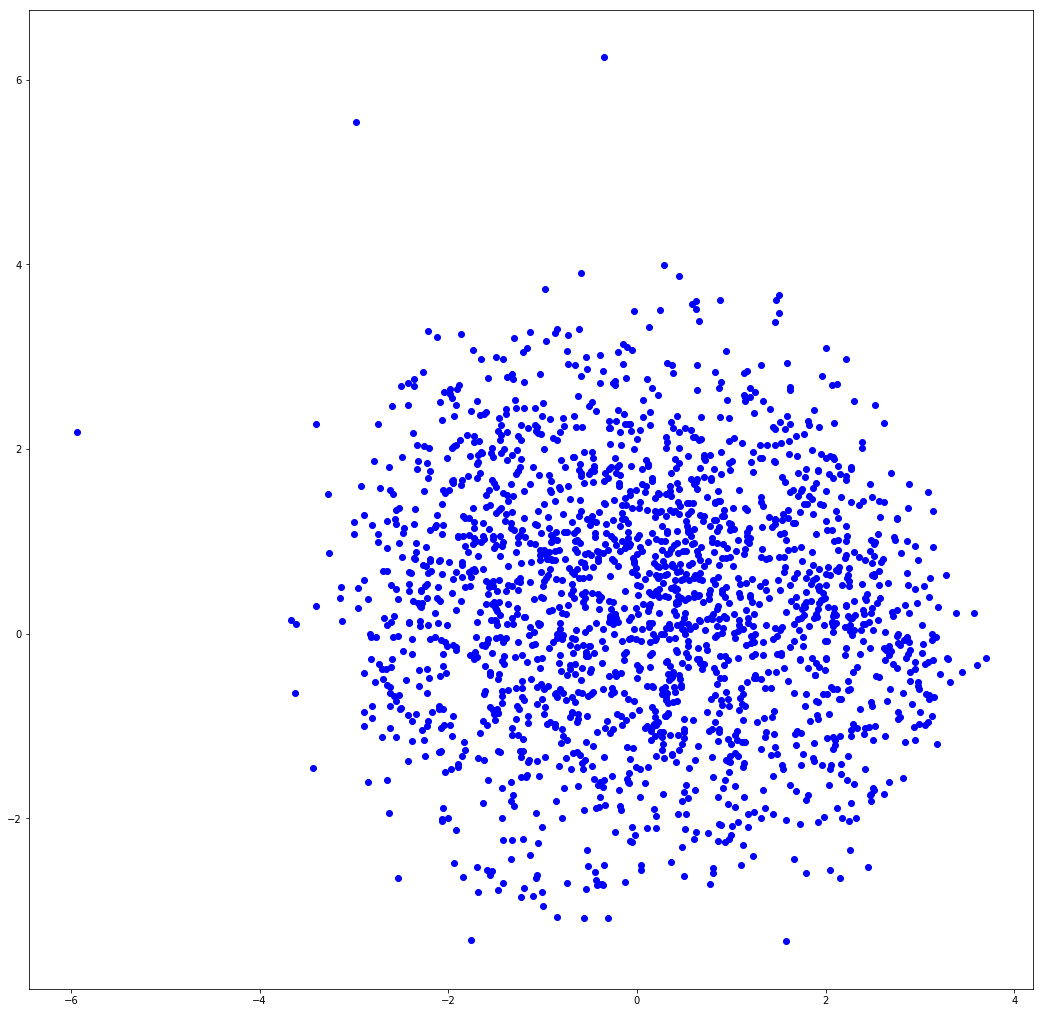

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

points = np.random.choice(len(labels), 2000, replace=False)

plt.figure(figsize=(18, 18))  #in inches
for i in points:
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y, color='b')
    #label = labels[i]
    #plt.annotate(
    #    label,
    #    xy=(x, y),
    #    xytext=(5, 2),
    #    textcoords='offset points',
    #    ha='right',
    #    va='bottom')

plt.show()

### Content-based User-Item: Avarage with Time Decay

In [12]:
import collections
import csv

MovieWatch = collections.namedtuple('MovieWatch', ['movie_id', 'timestamp'])

users = collections.defaultdict(list)
with open('movielens/ml-latest-small/ratings.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for user_id, item_id, _, timestamp in reader:
        users[user_id].append(MovieWatch(item_id, int(timestamp)))

len(users)

671

In [13]:
from scipy import stats

watch_counts = list(len(movies) for movies in users.values())
stats.describe(watch_counts)

DescribeResult(nobs=671, minmax=(20, 2391), mean=149.03725782414307, variance=53465.901594857314, skewness=4.544628118876825, kurtosis=28.18733851102888)

In [14]:
user_items = dict()
for user, movies in users.items():
    items = list()
    movies = sorted(movies, key=lambda m: int(m.timestamp))
    for movie_id, _ in movies:
        if movie_id not in train_corpus.document_to_idx:
            continue
        i = train_corpus.document_to_idx[movie_id]
        items.append(i)
    user_items[user] = items

stats.describe(list(len(items) for items in user_items.values()))

DescribeResult(nobs=671, minmax=(20, 2390), mean=149.00745156482861, variance=53434.461138421153, skewness=4.543685375623358, kurtosis=28.175458408361497)

In [ ]:
class Recommender:
    
    def __init__(self, item_embeddings, user_items, mapping, decay):
        self.item_embeddings = item_embeddings
        n_items = item_embeddings.shape[0]
        
        self.user_items = user_items
        self.user_u = dict()
        self.user_t = collections.defaultdict(int)
        self.user_h = collections.defaultdict(lambda: np.zeros(n_items))
        
        self.mapping = mapping
        self.decay = decay
    
    def user_vec(self, user_id, t):
        items = self.user_items[user_id]
        
        if t >= len(items):
            return self.user_u[user_id], self.user_h[user_id]
        
        i = items[t]
        v = self.item_embeddings[i]
        if t == 0:
            u = v
        else:
            u = v + self.decay * self.user_u[user_id]
            u = u / np.linalg.norm(u)
        self.user_u[user_id] = u
        h = self.user_h[user_id]
        h[i] = 1
        
        return u, h
        
    def recommend(self, user_id, k=3):
        if user_id not in self.user_items:
            return None
        
        t = self.user_t[user_id]
        self.user_t[user_id] += 1
        
        u, h = self.user_vec(user_id, t)
        
        d = np.dot(self.item_embeddings, u)
        d = np.multiply(d, 1 - h)
        rank = d.argsort()[::-1][:k]
        
        return list(self.mapping.document_from_idx[i] for i in rank)

In [23]:
user_id, items = list(user_items.items())[0]

print('{} (movies = {:,d})'.format(user_id, len(items)))
print()

rec = Recommender(docs_embeddings, user_items, train_corpus, 0.8)

for k, last_item in enumerate(items):
    print(train_corpus.title_from_idx(last_item))
    rec_items = rec.recommend(user_id)
    if k < len(items) - 10:
        continue
    print()
    for i, item_id in enumerate(rec_items):
        print('[ {} ] {}'.format(i+1, train_corpus.title_from_id(item_id)))
    print()

361 (movies = 70)

Toy Story (1995)
Sense and Sensibility (1995)
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Mission: Impossible (1996)
Twister (1996)
Independence Day (a.k.a. ID4) (1996)
Leaving Las Vegas (1995)
Grumpier Old Men (1995)
Star Wars: Episode IV - A New Hope (1977)
Executive Decision (1996)
Fargo (1996)
Rock, The (1996)
Eraser (1996)
Willy Wonka & the Chocolate Factory (1971)
Sabrina (1995)
River Wild, The (1994)
Dragonheart (1996)
Striptease (1996)
Nutty Professor, The (1996)
Star Trek: First Contact (1996)
Nixon (1995)
Mighty Aphrodite (1995)
Postman, The (Postino, Il) (1994)
Juror, The (1996)
Down Periscope (1996)
Primal Fear (1996)
Sgt. Bilko (1996)
Phenomenon (1996)
Time to Kill, A (1996)
Star Wars: Episode VI - Return of the Jedi (1983)
Trainspotting (1996)
Sudden Death (1995)
Up Close and Personal (1996)
James and the Giant Peach (1996)
Multiplicity (1996)
Barb Wire (1996)
Spy Hard (1996)
Hunchback of Notre Dame, The (1996)
Ransom (1996)
Tin Cup (1996)
Dracula: Dead a